In [1]:
# Imports
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2, os, gc

In [8]:
# Define Training Data
train_paths = [
    './data/train_image_data_0.parquet',
    './data/train_image_data_1.parquet',
    './data/train_image_data_2.parquet',
    './data/train_image_data_3.parquet'
]

test_paths = [
    './data/test_image_data_0.parquet',
    './data/test_image_data_1.parquet',
    './data/test_image_data_2.parquet',
    './data/test_image_data_3.parquet'
]

HEIGHT = 137
WIDTH = 236
SIZE = 299

In [9]:
# Make image dumping directory
train_dir_path = './data/images/train'
test_dir_path = './data/images/test'

if not os.path.isdir(train_dir_path):
    os.makedirs(train_dir_path)
    
if not os.path.isdir(test_dir_path):
    os.makedirs(test_dir_path)

In [10]:
# Define functions to crop and resize the images

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img, size, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [5]:
# Preprocess the Train images and write them down
for path in train_paths:
    df = pd.read_parquet(path)

    for row in tqdm(df.values):
        im_name = row[0]
        image = np.array(row[1:])
        image = 255 - image.reshape(HEIGHT, WIDTH).astype(np.uint8)
        image = (image*(255.0/image.max())).astype(np.uint8)
        image = crop_resize(image, SIZE, 20)
        _, image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, np.ones([3,3], np.uint8))
        cv2.imwrite(f"{os.path.join(train_dir_path, im_name)}.jpg", image)
    
    del df, row, im_name, image, _
    gc.collect()

In [16]:
# Preprocess the Test images and write them down
for path in test_paths:
    df = pd.read_parquet(path)

    for row in tqdm(df.values):
        im_name = row[0]
        image = np.array(row[1:])
        image = 255 - image.reshape(HEIGHT, WIDTH).astype(np.uint8)
        image = (image*(255.0/image.max())).astype(np.uint8)
        image = crop_resize(image, SIZE, 20)
        _, image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, np.ones([3,3], np.uint8))
        cv2.imwrite(f"{os.path.join(test_dir_path, im_name)}.jpg", image)
    
    del df, row, im_name, image
    gc.collect()

In [2]:
# Read train labels
train_label_path = "./data/train.csv"
df = pd.read_csv(train_label_path)

In [3]:
# Dropping the last column (not required for training)
df.drop(['grapheme'], axis=1, inplace=True)
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic
0,Train_0,15,9,5
1,Train_1,159,0,0
2,Train_2,22,3,5
3,Train_3,53,2,2
4,Train_4,71,9,5


In [4]:
# Separating the data from the labels and one hot encoding the labels
y_root = pd.get_dummies(df['grapheme_root'])
y_vowel = pd.get_dummies(df['vowel_diacritic'])
y_consonant = pd.get_dummies(df['consonant_diacritic'])
x_name = df['image_id']

In [5]:
# Train Test Split
x_train_name, x_val_name, y_root_train, y_root_val, y_vowel_train, y_vowel_val, y_consonant_tarin, y_consonant_val = train_test_split(x_name, y_root, y_vowel, y_consonant, test_size=0.2, random_state=3) 

In [6]:
# Verifying the shapes
x_train_name.shape, x_val_name.shape, y_root_train.shape, y_root_val.shape, y_vowel_train.shape, y_vowel_val.shape, y_consonant_tarin.shape, y_consonant_val.shape

((160672,),
 (40168,),
 (160672, 168),
 (40168, 168),
 (160672, 11),
 (40168, 11),
 (160672, 7),
 (40168, 7))

In [24]:
# Create the Data Generator
def data_generator(x, y_root, y_vowel, y_consonant, batch_size=16, saved_img_path='./data/images/train', image_shape=(299, 299)):
    assert len(x) == len(y_root) == len(y_vowel) == len(y_consonant), 'Lengths of all inputs should be same'
    
    num_splits = round(len(x) // batch_size) + 1
    
    x_splits = np.array_split(x, num_splits)
    
    print("Num Splits:", len(x_splits))
    
    y_root_splits = np.array_split(y_root, num_splits)
    y_vowel_splits = np.array_split(y_vowel, num_splits)
    y_consonant_splits = np.array_split(y_consonant, num_splits)    
    
    i = 0
    
    while True:
        xs = list()
        
        x_batch = x_splits[i].values
        y_root_batch = y_root_splits[i].values
        y_vowel_batch = y_vowel_splits[i].values
        y_consonant_batch = y_consonant_splits[i].values
        
        print("Other Shapes: ", end="")
        print(x_batch.shape, y_root_batch.shape, y_vowel_batch.shape, y_consonant_batch.shape)
        
        i += 1
        if i > num_splits-1: i = 0
        
        for x_ in x_batch:
            path = os.path.join(saved_img_path, f"{x_}.jpg")
            image = cv2.resize(cv2.imread(path, 0), image_shape, cv2.INTER_AREA)/255
            xs.append(image)
        
        yield x_batch, np.array(xs), [y_root_batch, y_vowel_batch, y_consonant_batch]
        

In [8]:
# Verifying the shapes
tx, tyr, tyv, tyc = x_train_name[:32], y_root_train[:32], y_vowel_train[:32], y_consonant_tarin[:32]

In [9]:
tx.shape, tyr.shape, tyv.shape, tyc.shape

((32,), (32, 168), (32, 11), (32, 7))

In [25]:
gen = data_generator(tx, tyr, tyv, tyc, batch_size=5)
xs, ys = gen.__next__()

Num Splits: 7
Other Shapes: (5,) (5, 168) (5, 11) (5, 7)


Root: 79
Vowel: 4
Consonant: 5


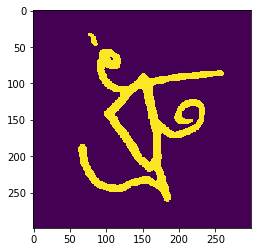

In [28]:
k = 0
print("Root:", np.argmax(ys[0][k]))
print("Vowel:", np.argmax(ys[1][k]))
print("Consonant:", np.argmax(ys[2][k]))
plt.imshow(xs[k])
plt.show()